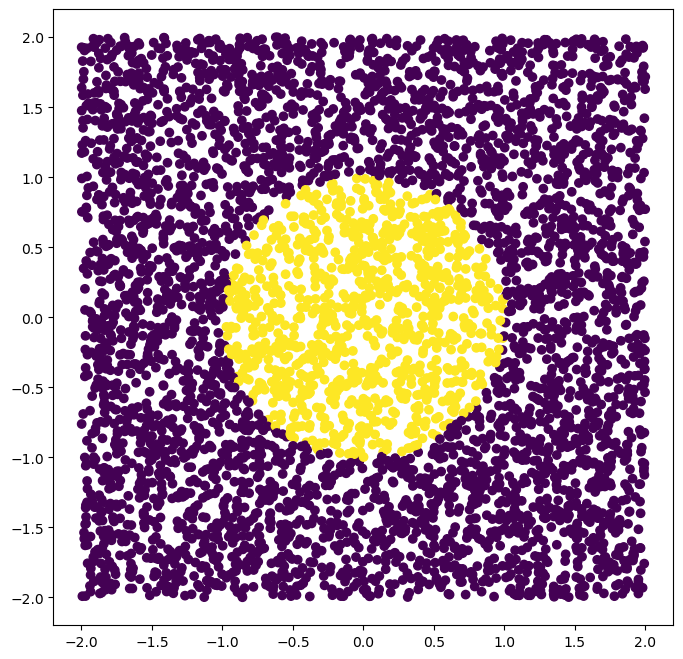

In [1]:
import numpy as np
import pandas as pd
from sklearn.base import BaseEstimator, ClassifierMixin
from sklearn.utils.validation import check_array
from sklearn.utils.multiclass import unique_labels
from sklearn.metrics.pairwise import cosine_similarity
from scipy.special import gammainccinv, gamma
from sklearn.linear_model import Ridge
import lime
import lime.lime_tabular
from sklearn.metrics import pairwise_distances
import matplotlib.pyplot as plt
from math import inf

class SphereClassifier(BaseEstimator, ClassifierMixin):
    def __init__(self, radius=1):
        self.radius = radius

    def fit(self, X, y):
      raise NotImplementedError("You should not call fit()")

    def predict(self, X):
        # Input validation
        X = check_array(X)
        
        # Sphere model
        return np.linalg.norm(X, axis=1, ord=2) <= 1
        
        # Box model
        #return np.linalg.norm(X, axis=1, ord=inf) <= 1
        #return np.max(np.abs(X), axis=1) < 1
      
    def predict_proba(self, X):
        p = self.predict(X)
        return np.array([p, 1-p]).transpose()

clf = SphereClassifier()
      
## Sanity check  
X = np.random.uniform(-2, 2, (5000, 2))
yss = clf.predict_proba(X)[:,0]
plt.figure(figsize=(8,8))
SLICE = (0,1)
plot = plt.scatter(X[:,SLICE[0]], X[:,SLICE[1]], c=yss)
plt.show()

In [2]:
from sklearn.preprocessing import normalize
from bisect import bisect
from scipy.optimize import newton
from functools import partial
from sklearn.linear_model import Ridge
from sklearn.utils import check_random_state
from sklearn.preprocessing import StandardScaler, MinMaxScaler


class LemonExplainer(object):
  """
  Intantiates the explainer.
  """
  def __init__(self, training_data, distance_kernel=None, sample_size = 5000, radius_max=1, random_state=None):
    self.random_state = check_random_state(random_state)
    np.random.seed(random_state)

    self.training_data = training_data
    self.scaler = StandardScaler(with_mean=False)
    self.scaler.fit(training_data)
    
    # Create hypersphere samples. The sphere is only computed once for performance and stability,
    # but it would be better to resample the sphere every time `explain_instance` is called.
    # I checked, this does not affect the results in any way.
    dimensions = training_data.shape[1]

    if distance_kernel is None:
      self.distance_kernel = np.vectorize(lambda x: x ** (1 / dimensions))
    else:
      self.distance_kernel = np.vectorize(self._transform(distance_kernel, dimensions, radius_max=radius_max))

    sphere = np.random.normal(size=(sample_size, dimensions))
    sphere = normalize(sphere)
    sphere *= self.distance_kernel(np.random.uniform(size=sample_size)).reshape(-1,1)
    
    self.sphere = sphere

  @property
  def surrogate(self):
    try:
      return self._surrgate
    except AttributeError:
      self._surrogate = Ridge(alpha=0, fit_intercept=True, normalize=True, random_state=self.random_state)
      return self._surrogate

  def explain_instance(self, instance, predict_fn, labels=(1,), surrogate=None):
    surrogate = surrogate or self.surrogate
  
    # Create transfer dataset by perturbing the original instance with the hypersphere samples
    X_transfer = self.scaler.inverse_transform(self.sphere) + np.array([instance])
    y_transfer = predict_fn(X_transfer)

    def explain_label(label):
      surrogate.fit(X_transfer, y_transfer[:,label])
      score = surrogate.score(X_transfer, y_transfer[:,label])
      return (surrogate.coef_, score)

    return [explain_label(label) for label in labels]

  def _transform(self, kernel, dimensions, sample_size = 1000, radius_max=1): 
    """
    Inverse transform sampling
    """
    cdf_samples = np.array([kernel(x)*(x**(dimensions-1)) for x in np.linspace(0, radius_max, sample_size)])
    cdf_samples = np.cumsum(cdf_samples)
    cdf_samples /= cdf_samples[-1]
    return lambda y: radius_max * (bisect(cdf_samples, y) / sample_size)


def uniform_kernel(x):
    return 1


def gaussian_kernel(x, kernel_width):
    # https://github.com/marcotcr/lime/blob/fd7eb2e6f760619c29fca0187c07b82157601b32/lime/lime_tabular.py#L251
    return np.sqrt(np.exp(-(x ** 2) / kernel_width ** 2))

  
def sqcos_kernel(x):
    return np.cos(x)**2

  
def trapezoid_kernel(x, a, b):
    if 0 <= x and  x <= a:
        return (2 / (a + b))
    elif a <= x and x <= b:
        return (2 / (a + b)) * ((b - x) / (b - a))
    else: 
        return 0

In [3]:
# For the `plot_sample_data` debug feature in the next cell, you need to patch LIME as such:

# Change return statement from `explain_instance_with_data` (lime_base.py:204) to

#         return (easy_model.intercept_,
#                 sorted(zip(used_features, easy_model.coef_),
#                        key=lambda x: np.abs(x[1]), reverse=True),
#                 prediction_score, local_pred, neighborhood_data[:, used_features], weights)
                
# And `ret_exp` in `explain_instance` (lime_tabular.py:450) to

#             (ret_exp.intercept[label],
#              ret_exp.local_exp[label],
#              ret_exp.score, ret_exp.local_pred, ret_exp.data, ret_exp.weights) = self.base.explain_instance_with_data(
#                     scaled_data,
#                     yss,
#                     distances,
#                     label,
#                     num_features,
#                     model_regressor=model_regressor,
#                     feature_selection=self.feature_selection)

In [4]:
def do_experiment(Xtr, DIMENSIONS, KERNEL_SIZE, plot_sample_data=False):
  sample_size_lime = 5000
  sample_size_lemon = 5000

  p = 0.999
  kernel_width_lime = KERNEL_SIZE
  radius = KERNEL_SIZE * np.sqrt(2*gammainccinv(DIMENSIONS/2, (1-p)))
  kernel_width_lemon = KERNEL_SIZE
  diameter = radius * 2
  
  # explainers
  surrogate_lime = Ridge(fit_intercept=False, random_state=123)
  explainer_lime = lime.lime_tabular.LimeTabularExplainer(
      Xtr, 
      kernel_width=kernel_width_lime,
      feature_selection='none',
      sample_around_instance=True, # Important! Essentially: True = synthetic, False = observation-based sampling
      discretize_continuous=False
  )

  surrogate_lemon = Ridge(fit_intercept=False, random_state=123)
  explainer_lemon = LemonExplainer(
      Xtr, 
      sample_size=sample_size_lemon, 
      #distance_kernel=uniform_kernel, 
      distance_kernel=partial(gaussian_kernel, kernel_width=kernel_width_lemon),
      radius_max=radius
  )
  
  # Generate explanation for test instance at surface of sphere/box
  testInstance = (np.zeros(DIMENSIONS), 1)
  testInstance[0][0] = 1

  explanation_lime = explainer_lime.explain_instance(
      testInstance[0], 
      clf.predict_proba, 
      num_samples=sample_size_lime, 
      labels=(testInstance[1],), 
      model_regressor=surrogate_lime
  )

  explanation_lemon = explainer_lemon.explain_instance(
      testInstance[0], 
      clf.predict_proba,
      labels=(testInstance[1],),
      surrogate=surrogate_lemon
  )
  
  # Evaluate with cosine similarity between coefficients

  # Note: should make sure the surrogate model does not fit an intercept for this to work! -> `Ridge(fit_intercept=False, ...)`
  perfect_surrogate = np.zeros(DIMENSIONS)
  perfect_surrogate[0] = 1

  #pd.DataFrame(surrogate_lime.coef_).plot.bar(color='green',figsize=(5, 2))
  #plt.savefig("example_lime.pdf")
  #pd.DataFrame(surrogate_lemon.coef_).plot.bar(color='orange',figsize=(5, 2))
  #plt.savefig("example_lemon.pdf")
  #pd.DataFrame(perfect_surrogate).plot.bar(color='blue',figsize=(5, 2))
  #plt.savefig("example_truth.pdf")
  lime_fidelity = cosine_similarity([surrogate_lime.coef_], [perfect_surrogate])[0]
  lemon_fidelity = cosine_similarity([surrogate_lemon.coef_], [perfect_surrogate])[0]
  
  # Plot sampled points (This requires patching LIME! See previous cell.)
  if plot_sample_data:
    from matplotlib.patches import Ellipse
    slice = (0,1)

    # LIME
    plt.figure(figsize=(5, 5))
    plt.xlim(np.min(Xtr[:,slice[0]]) + 1, np.max(Xtr[:,slice[0]]) + 1)
    plt.ylim(np.min(Xtr[:,slice[1]]), np.max(Xtr[:,slice[1]]))

    data = (explanation_lime.data * explainer_lime.scaler.scale_) + explainer_lime.scaler.mean_
    plt.scatter(data[:,slice[0]], data[:,slice[1]], alpha=1, s=np.around(explanation_lime.weights*10, decimals=7) + 0.05, cmap='coolwarm', c=clf.predict_proba(data)[:,0])
    plt.title("LIME transfer data (labeled by reference model)")

    w, h = explainer_lime.scaler.inverse_transform([np.repeat(diameter, DIMENSIONS)])[0, slice]
    plot = plt.scatter(testInstance[0][slice[0]], testInstance[0][slice[1]], s=100, marker='s' )
    circle = Ellipse((testInstance[0][slice[0]], testInstance[0][slice[1]]), width=w, height=h, color='r', fill=False)
    plot.axes.add_artist(circle)
    plt.show()

    # LEMON
    plt.figure(figsize=(5, 5))
    plt.xlim(np.min(Xtr[:,slice[0]]) + 1, np.max(Xtr[:,slice[0]]) + 1)
    plt.ylim(np.min(Xtr[:,slice[1]]), np.max(Xtr[:,slice[1]]))

    X_transfer = explainer_lemon.scaler.inverse_transform(explainer_lemon.sphere) + np.array([testInstance[0]])
    plt.scatter(X_transfer[:,slice[0]], X_transfer[:,slice[1]], cmap='coolwarm', s=1, c=clf.predict_proba(X_transfer)[:,0])
    plt.title("LEMON transfer data (labeled by reference model)")
    
    w, h = explainer_lemon.scaler.inverse_transform([np.repeat(diameter, DIMENSIONS)])[0, slice]
    plot = plt.scatter(testInstance[0][slice[0]], testInstance[0][slice[1]], s=100, marker='s')
    circle = Ellipse((testInstance[0][slice[0]], testInstance[0][slice[1]]), width=w, height=h, color='r', fill=False)
    plot.axes.add_artist(circle)
    plt.show()
  
  return lime_fidelity, lemon_fidelity



## Sanity check (This requires patching LIME! See previous cell.)
# dims = 2
# X = np.array([np.array([-1 for d in range(0,dims)]), np.array([1 for d in range(0,dims)])])
# do_experiment(X, dims, 0.15, plot_sample_data=True)

In [5]:
from tqdm.notebook import tqdm

DIMENSIONS = np.arange(2, 100, 1)
KERNEL_SIZES = np.around(np.arange(0.1, 0.5, 0.1), decimals=2)

results_lime = pd.DataFrame(np.zeros((len(DIMENSIONS), len(KERNEL_SIZES))), columns = KERNEL_SIZES, index=DIMENSIONS)
results_lemon = pd.DataFrame(np.zeros((len(DIMENSIONS), len(KERNEL_SIZES))), columns = KERNEL_SIZES, index=DIMENSIONS)

for dimensions in tqdm(DIMENSIONS):
  for kernel_size in KERNEL_SIZES:
    X = np.array([np.array([-1 for d in range(0,dimensions)]), np.array([1 for d in range(0,dimensions)])])
    lime_result, lemon_result = do_experiment(X, dimensions, kernel_size)
    results_lime[kernel_size][dimensions] = lime_result
    results_lemon[kernel_size][dimensions] = lemon_result

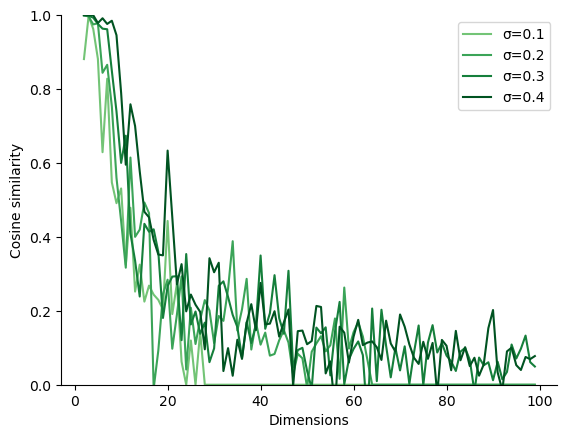

In [6]:
import matplotlib.cm as cm
colors = cm.Greens(np.linspace(0.5,0.95,results_lime.shape[1]))
results_lime.columns = [f'σ={x}' for x in KERNEL_SIZES]
ax = results_lime.plot.line(color=colors, ylim=[0,1], xlabel="Dimensions", ylabel="Cosine similarity")

ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)

plt.show()
#plt.savefig("lime.pdf")

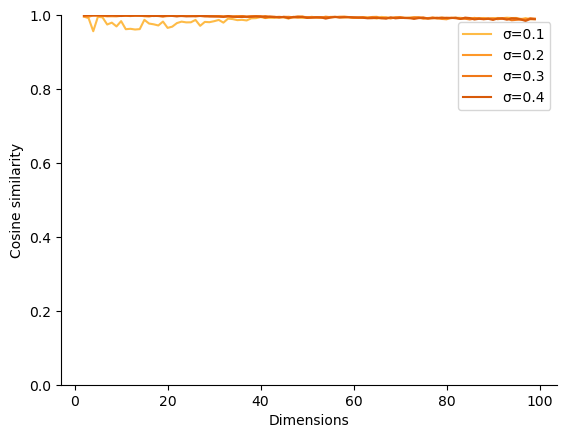

In [7]:
import matplotlib.cm as cm
colors = cm.YlOrBr(np.linspace(0.4, 0.7,results_lime.shape[1]))
results_lemon.columns = [f'σ={x}' for x in KERNEL_SIZES]
ax = results_lemon.plot.line(color=colors, ylim=[0,1], xlabel="Dimensions", ylabel="Cosine similarity")

ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)

plt.show()
#plt.savefig('lemon.pdf')  